# Carbon intensity cap models

Load packages, load data

In [2]:
import numpy as np
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cmocean import cm as cmo
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

import torch
import torch.nn as nn

In [3]:
flights = pd.read_csv("../data/by_route_airline_fuel_burn.csv")
flights

,departure,arrival,arrival_longitude,arrival_latitude,departure_longitude,departure_latitude,airlinename,aircraft_types,avg_distance,flown_distance,gcd,flights,passengers,seats,rpk,average_load,co2,gco2_pax_km,idx,fuel_burn
0,ABZ,LTN,-0.368333,51.874699,-2.197780,57.201900,Easyjet,2,704.642441,212097.374774,181997.374774,301,44357.976812,48816,3.125651e+07,0.908677,3002.609769,96.063491,0,14.431673
1,ABZ,GVA,6.108950,46.238098,-2.197780,57.201900,Easyjet,1,1445.993886,11567.951085,10767.951085,8,1352.111388,1488,1.955145e+06,0.908677,138.997051,71.092970,1,14.054054
2,ABZ,LGW,-0.190278,51.148102,-2.197780,57.201900,Easyjet,2,786.430229,483654.591061,422154.591061,615,88241.624226,97110,6.939588e+07,0.908677,6598.559818,95.085756,2,15.723270
3,ACE,BER,13.500672,52.362247,-13.605200,28.945499,Easyjet,1,3528.958906,84695.013743,82295.013743,24,3990.909418,4392,1.408376e+07,0.908677,890.172346,63.205610,3,12.558140
4,ACE,AMS,4.763890,52.308601,-13.605200,28.945499,Easyjet,1,3109.370578,83953.005610,81253.005610,27,4563.375933,5022,1.418923e+07,0.908677,890.314645,62.745818,4,16.774193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81839,YZF,YSG,-110.681999,62.418304,-114.440002,62.462799,Air Tindi Ltd,1,243.596030,18756.894297,14906.894297,77,1148.548823,1463,2.797819e+05,0.785064,87.634275,313.223496,81839,11.111111
81840,YMX,YVO,-77.782799,48.053299,-74.038696,45.679501,Nolinor Aviation,1,438.556458,83325.726966,73825.726966,190,17750.299988,22610,7.784509e+06,0.785064,1285.121719,165.087069,81840,20.536379
81841,YVO,YMX,-74.038696,45.679501,-77.782799,48.053299,Nolinor Aviation,1,438.556458,83325.726966,73825.726966,190,17750.299988,22610,7.784509e+06,0.785064,1285.121719,165.087069,81841,16.037735
81842,YVR,YYD,-127.182999,54.824699,-123.183998,49.193901,Central Mountain Air Ltd.,1,783.845438,20379.981386,17779.981386,26,755.231693,962,5.919849e+05,0.785064,75.523169,127.576171,81842,16.911764


# Data

In [82]:
sample = np.arange(len(flights))
sample_random = np.copy(sample)
np.random.shuffle(sample_random)      # randomize
sample_random

array([45534, 50964, 30856, ..., 74158,  7066, 41827], shape=(81844,))

In [124]:
# predictors
average_load = np.array(flights["average_load"])[sample_random]
distance = np.array(flights["avg_distance"])[sample_random]
burn = np.array(flights["fuel_burn"])[sample_random]

# predictand
intensity = np.array(flights["gco2_pax_km"])[sample_random]

# normalize
all_data = np.vstack((intensity, average_load, np.log(distance)/10, burn/50), dtype=np.float32).T

train_data = all_data
test_data = all_data[-10_000:,:]

In [199]:
from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, ind):
        x = self.data[ind][1:]
        y = self.data[ind][0]
        return x, y
        
class TestDataset(TrainDataset):
    def __getitem__(self, ind):
        x = self.data[ind]
        return x

train_set = TrainDataset(train_data)
test_set  = TestDataset(test_data)

batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

## Define a Multi-layer perceptron

In [200]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

## Do the training

In [201]:
epochs = 1

model.train()
for epoch in range(epochs):
    losses = []
    for batch_num, input_data in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = input_data
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()

        # if batch_num % 40 == 0:
        #     print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
    print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))

/Users/milan/miniforge3/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 | Loss 1409.22


/Users/milan/miniforge3/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


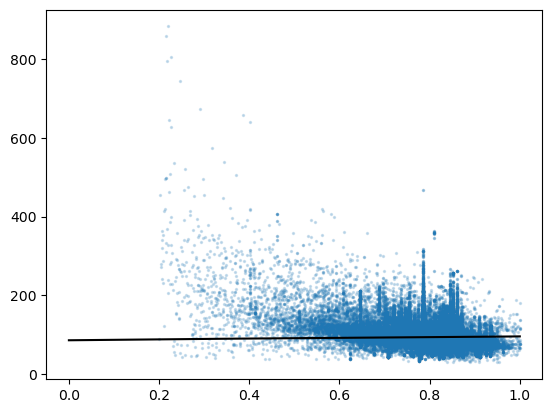

In [202]:
plt.scatter(average_load, intensity, 2, alpha=0.2)

x = np.linspace(0, 1, 100, dtype=np.float32)
base_distance = np.log(1000) / 10
base_burn = 15 / 50

X = torch.from_numpy(np.vstack((x, base_distance*np.ones_like(x), base_burn*np.ones_like(x)), dtype=np.float32).T)
y = model(X).detach().numpy()

plt.plot(x, y, 'k')

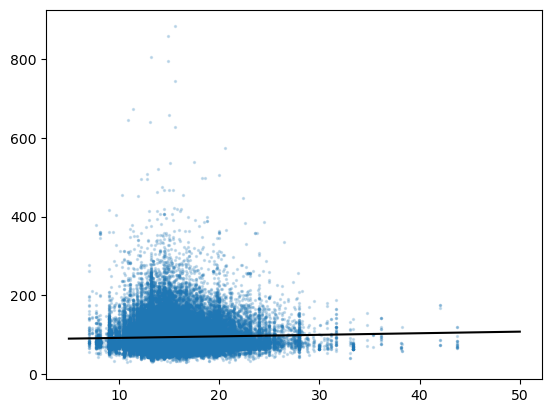

In [203]:
plt.scatter(burn, intensity, 2, alpha=0.2)

x = np.linspace(5, 50, 100, dtype=np.float32)
base_load = 0.8

X = torch.from_numpy(np.vstack((base_load*np.ones_like(x), base_distance*np.ones_like(x), x/50), dtype=np.float32).T)
y = model(X).detach().numpy()

plt.plot(x, y, 'k')

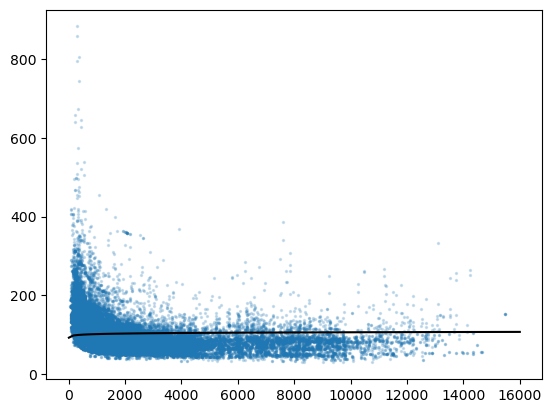

In [204]:
plt.scatter(distance, intensity, 2, alpha=0.2)

x = np.linspace(10, 16_000, 100, dtype=np.float32)
base_load = 0.8

X = torch.from_numpy(np.vstack((base_load*np.ones_like(x), base_distance*np.ones_like(x), np.log(x)/10), dtype=np.float32).T)
y = model(X).detach().numpy()

plt.plot(x, y, 'k')